# Introduction

This notebook fits 3 different classification machine learning models onto the various training datasets and compares the results

The 3 models used are:

    1) Gaussian Naive Bayes

    2) Random Forest

    3) eXtreme Gradient Boosting (XGBoost)

# Import Libraries

In [1]:
# Dataframes
import pandas as pd
import numpy as np

# Model Tuning and Cross Validation
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

# # Model metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

# # Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
# Import functions.py file
import sys
sys.path.append('../')

from functions.functions import *

In [3]:
random_seed = 1

# Import Datasets

## Import Training Datasets

In [23]:
# Original Training Dataset
X_train = pd.read_csv('../data/processed/x_train.gz', compression='gzip')
y_train = pd.read_csv('../data/processed/y_train.gz', compression='gzip')
y_train.dropna(inplace=True)

# Training Dataset resampled with SMOTE
X_train_smote = pd.read_csv('../data/processed/x_train_smote.gz', compression='gzip')
y_train_smote = pd.read_csv('../data/processed/y_train_smote.gz', compression='gzip')
y_train_smote.dropna(inplace=True)

# Training Dataset resampled with Random Undersampling
X_train_under = pd.read_csv('../data/processed/x_train_under.gz', compression='gzip')
y_train_under = pd.read_csv('../data/processed/y_train_under.gz', compression='gzip')
y_train_under.dropna(inplace=True)

# Training Dataset resampled with SMOTE and Random Undersampling
X_train_smote_under = pd.read_csv('../data/processed/x_train_smote_under.gz', compression='gzip')
y_train_smote_under = pd.read_csv('../data/processed/y_train_smote_under.gz', compression='gzip')
y_train_smote_under.dropna(inplace=True)

## Import Test Datasets

In [24]:
X_test = pd.read_csv('../data/processed/x_test.gz', compression='gzip')
y_test = pd.read_csv('../data/processed/y_test.gz', compression='gzip')
y_test.dropna(inplace=True)

# Modelling

## Dataframe to keep track of Scores

In [25]:
# Build scores dataframes for comparison
scores_columns = ['Original', 'SMOTE', 'Undersampled', 'SMOTE & Undersampled']
# F1 scores
f1_scores_df = pd.DataFrame(columns=scores_columns)
# Recall scores
recall_scores_df = pd.DataFrame(columns=scores_columns)

## GridSearch

* The function we use makes use of sklearn's GridSearchCV function.  
* Grid Search is an exhaustive search using the parameter values that we provide, in order to optimize our model
    * Not every possible parameter combination is tested, so we can not guarantee a globally optimal combination of parameter values.
    * The model will ony be as good as the possible combinations of parameters that we provide.
    * the more parameter combinations we input, the longer the model will take to run

## Baseline Model & Model Metrics

Due to the high imbalance in our dataset, it is very easy to obtain a high accuracy by simply classifying every observation as the majority class (non-fraud).

In [27]:
# Baseline model that all predictions are majority class
y_pred_base = [0] * len(y_test)

# Calculate Accuracy of Baseline Model
acc_base = round(accuracy_score(y_test, y_pred_base), 5)
print('Baseline Model Accuracy: {}'.format(acc_base))

Baseline Model Accuracy: 0.99739


A model with this level of accuracy will initially seem highly successful, but once we realise it has not caught a single fraudulent transaction, we then realise that **we need a different performance metric to accuracy**.  
   * 99.83% Accuracy can still be used as a starting point, or baseline, from which more sophisticated models can improve upon.

Alternative metrics to Accuracy include:  

### Precision 
* Out of all the frauds our model predicted, what proportion were actually frauds?

\begin{equation*}
\frac{True Positives}{True Positives + False Positives}
\end{equation*}

### Recall
* Out of all the actual frauds, what proportion did our model detect?

\begin{equation*}
\frac{True Positives}{True Positives + False Negatives}
\end{equation*}

### F1 Score
* Considers both Precision and Recall.  Can be interpreted as a weighted average of the two (harmonic mean)

\begin{equation*}
2*\frac{Precision * Recall}{Precision + Recall}
\end{equation*}


**To avoid confusion in this project, True Positive refers to predicting fraud and it is a fraud.**

When seeking to classify fraudulent transactions, the **cost for misclassifying frauds** (False Negative) **is greater than misclassifying a legitimate transaction** (False Positive).
   * An undetected fraud could potentially cost the customer and bank a lot of money.
   * A legitimate transaction, flagged as fraud, may cause inconvenience for the customer and requires a team within the bank to authorize the transaction.
   
For our model we will **focus on the F1 Score** and place more emphasis on a high **Recall** rather than Precision.
* The F1 Score will be the most useful metric as it is includes Recall and Precision.
* Focusing on Recall as well, reflects the fact that classifying frauds (class 1) is more important than classifying legitimate transactions (class 0).

Confusion Matrix: 
TN: 25255 FP: 0 FN: 66 TP: 0


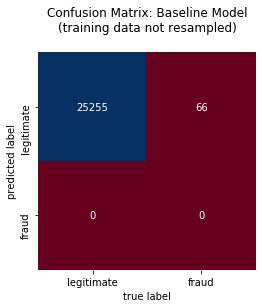

In [30]:
# Confusion matrix for baseline model
custom_confusion_matrix(y_test, y_pred_base, 'Baseline', 'not resampled')

In [31]:
# Calculate F1 Score of Baseline Model
f1_base = round(f1_score(y_test, y_pred_base), 8)
print('Baseline Model F1 Score: {}'.format(f1_base))

# Calculate Recall of Baseline Model
recall_base = round(recall_score(y_test, y_pred_base), 8)
print('Baseline Mode Recall Score: {}'.format(recall_base))

Baseline Model F1 Score: 0.0
Baseline Mode Recall Score: 0.0


Baseline Model's F1 Score and Recall are 0 as the baseline model has a True Positive of 0.

In [32]:
# Update F1 Scores table
f1_scores_df.loc['Baseline'] = [f1_base] * 4

# Update Recall Scores table
recall_scores_df.loc['Baseline'] = [recall_base] * 4

## Gaussian Naive Bayes (GNB)

This classification method is based on Bayes' Theorem and although it is one of the earliest classification techniques, it is still extremey powerful.  

The classifier is essentially asking, "given the Amount = X, the V1 = Y, V2 = Z etc...what is the most likely Class for this observation?"

In [33]:
# Instantiate Gaussian Naive Bayes Classifer
clf_gnb = GaussianNB()

# Build Parameter Grid
param_grid_gnb = {}

### Gaussian Naive Bayes - Original Dataset

In [34]:
# Gaussian Bayes with SMOTE training data
f1_gnb_original, recall_gnb_original, y_pred_gnb_original, y_pred_proba_gnb_original = best_model_score(clf_gnb, param_grid_gnb, X_train, y_train, X_test, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [199364, 139720]